<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/soil_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import geopandas as gpd

In [62]:
# Define the generator model
def build_generator(latent_dim, sequence_length):
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_dim=latent_dim),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(sequence_length, activation='tanh')
    ])
    return model

In [63]:
# Define the discriminator model
def build_discriminator(sequence_length):
    model = models.Sequential([
        layers.Dense(1024, activation='relu', input_dim=sequence_length),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [64]:

# Define the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential([
        generator,
        discriminator
    ])
    return model


In [65]:
# Update the training function to include validation
def train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, val_gen,keep_cols = [0,1,2,3]):
    for epoch in range(epochs):
        # Train on batches from the training generator
        for _ in range(len(train_sequences) // batch_size):
            # Generate fake sequences
            noise = tf.random.normal(shape=(batch_size, latent_dim))
            fake_sequences = generator.predict(noise)

            # Get a batch of real sequences from the training generator
            real_sequences = next(train_gen)

            # Labels for real and fake data
            real_labels = tf.ones((batch_size, 1))
            fake_labels = tf.zeros((batch_size, 1))

            # Train the discriminator
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_sequences, fake_labels)
            d_loss = 0.5 * tf.add(d_loss_real, d_loss_fake)

            # Train the generator
            discriminator.trainable = False
            noise = tf.random.normal(shape=(batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real_labels)

        # Validation
        val_real_sequences = next(val_gen)
        val_fake_sequences = generator.predict(tf.random.normal(shape=(batch_size, latent_dim)))
        val_d_loss_real = discriminator.evaluate(val_real_sequences, tf.ones((batch_size, 1)), verbose=0)
        val_d_loss_fake = discriminator.evaluate(val_fake_sequences, tf.zeros((batch_size, 1)), verbose=0)
        val_d_loss = 0.5 * np.add(val_d_loss_real, val_d_loss_fake)

        # Print the progress
        print(f"Epoch: {epoch+1}/{epochs}, D Loss: {d_loss}, G Loss: {g_loss}, Val D Loss: {val_d_loss}")


        if epoch % 100 == 0:
          # data = validate_generator()
          data = validate_generator(keep_cols = keep_cols)
          x_values = [ datum[0] for datum in data]
          y_values = [ datum[1] for datum in data]

          # Create a scatter plot
          plt.scatter(x_values, y_values, color='blue')

          # Add labels and title
          plt.xlabel('Sample Index')
          plt.ylabel('Difference between Real and Generated')
          plt.title('Scatter Plot of Validation Differences')

          # Show the plot
          plt.show()


In [66]:
def validate_generator(n_lowest = 10, n_samp = 256,keep_cols = [0,1,2,3]):
  # n_lowest = 10
  result_vec = []

  batch_val = next(val_gen)
  for batch_ in batch_val:
    noise = tf.random.normal(shape=(n_samp, latent_dim))
    synthetic_samples = generator.predict(noise)
    # batch_ = batch_val[1]
    match_indices = [i for i in range(len(keep_cols)-1)]
    # keep_cols[:(len(keep_cols)-1)]

    data = [np.mean(np.sqrt((batch_[match_indices] - samp[match_indices])**2)) for samp in synthetic_samples]

    indices = sorted(range(len(data)), key=lambda i: data[i])[:n_lowest]

    lowest_data = [data[i] for i in indices]

    most_similar = [synthetic_samples[i] for i in indices]

    most_similar_scaled_df = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(most_similar, columns=numeric_cols.columns)), columns=numeric_cols.columns)

    original_scaled_df = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(batch_.reshape(1,-1), columns=numeric_cols.columns)), columns=numeric_cols.columns)

    error_vec = [np.mean(original_scaled_df["imp_c_float"]) ,np.mean(most_similar_scaled_df["imp_c_float"]) ]

    # # most_similar_scaled_df = scaler.inverse_transform( most_similar_df)

    # original_scaled = [scaler.inverse_transform(sim.reshape(1,-1)) for sim in [batch_]]

    # most_similar_scaled_2d = [np.squeeze(sim) for sim in most_similar_scaled]

    # original_scaled_2d = [np.squeeze(sim) for sim in original_scaled]

    # most_similar_scaled_df = pd.DataFrame(most_similar_scaled_2d, columns=numeric_cols.columns)

    # original_scaled_df = pd.DataFrame(original_scaled_2d, columns=numeric_cols.columns)

    # result = [np.mean(most_similar_scaled_df['imp_c_float']), np.mean(original_scaled_df['imp_c_float'])]
    # print(np.mean(original_scaled_df['agbd_m']))
    result_vec.append(error_vec)
  return(result_vec)

In [67]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [68]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [69]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [70]:
from shapely.geometry import Point

soils_csv = soils_csv[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'] )), axis=1)
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")

In [247]:
# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [251]:
# matched_data

In [249]:
unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
# unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
unique_rows = unique_rows[unique_rows['distance'] < 251]
matched_data = unique_rows

In [252]:
matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]

In [253]:
import numpy as np
len(matched_data.select_dtypes(include=[np.number]).columns)

39

In [75]:
matched_data.columns

Index(['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top',
       'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude', 'c_perc',
       'imp_c', 'bulk_density', 'imp_bd', 'hole_id', 'geometry', 'index_right',
       'id', 'left', 'top', 'right', 'bottom', 'water', 'trees', 'grass',
       'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare',
       'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI', 'aet',
       'def', 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn', 'tmmx',
       'vap', 'vpd', 'vs', 'agbd_m', 'agbd_sd', 'agbd_n', 'majorcomposition',
       'age_years', 'age_class', 'distance', 'imp_c_float'],
      dtype='object')

In [76]:
matched_data.columns[31]

'elevation'

In [ ]:
matched_data.columns[48]

'agbd_m'

In [254]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
# Select only numeric columns
numeric_cols = matched_data.iloc[:,keep_cols]
numeric_cols.replace('', np.nan, inplace=True)
numeric_cols = numeric_cols.astype(float)
numeric_cols.fillna(0, inplace=True)

# Initialize the scaler
scaler = MinMaxScaler ()

# Fit the scaler on the numeric columns
scaler.fit(numeric_cols)

# Transform the numeric columns
scaled_numeric_cols = scaler.transform(numeric_cols)

# Convert the scaled numeric columns back to a DataFrame
scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

# scaled_numeric_df = scaled_numeric_df
# Concatenate the ID fields back with the numeric columns
numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

<ipython-input-254-7306ae049bea>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [186]:
len(scaled_numeric_df.columns)

28

In [255]:
from tensorflow.keras.optimizers import Adam

# Set the dimensions and compile the models
latent_dim = 100
sequence_length = len(keep_cols)  # Adjust based on your sequence length

generator = build_generator(latent_dim, sequence_length)
discriminator = build_discriminator(sequence_length)
gan = build_gan(generator, discriminator)

# Set the initial learning rate
initial_learning_rate = 0.000001

# Create optimizers for the generator and discriminator
generator_optimizer = Adam(learning_rate=initial_learning_rate, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=initial_learning_rate, beta_1=0.5)
gan_optimizer = Adam(learning_rate=initial_learning_rate, beta_1=0.5)

# Compile the discriminator
generator.compile(optimizer=generator_optimizer, loss='mse', metrics=['accuracy'])

# Compile the discriminator
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Compile the GAN
gan.compile(optimizer=gan_optimizer, loss='mse')

# # Assuming 'final_df' is your scaled dataset with numeric columns and ID fields
# # Extract only the numeric columns for the GAN
# numeric_columns = [col for col in scaled_numeric_cols.columns if scaled_numeric_cols[col].dtype in [np.float32, np.float64]]
# real_sequences_df = scaled_numeric_cols[numeric_columns]

# Convert the DataFrame to a NumPy array
real_sequences_array = scaled_numeric_cols

def real_sequence_generator(data, batch_size):
    while True:
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            # If the batch is smaller than the batch size, pad it with samples from the beginning
            if len(batch) < batch_size:
                padding = data[:(batch_size - len(batch))]
                batch = np.concatenate([batch, padding], axis=0)
            yield batch


def real_sequence_generator(data, batch_size):
    while True:
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            # If the batch is smaller than the batch size, pad it with samples from the beginning
            if len(batch) < batch_size:
                padding = data[:(batch_size - len(batch))]
                batch = np.concatenate([batch, padding], axis=0)
            # Separate the input and output sequences
            input_sequences = batch[:, :-1]  # First 3 elements as input
            output_sequences = batch[:, -1]  # Last element as output
            yield input_sequences, output_sequences

In [119]:
def real_sequence_generator(data, batch_size):
    while True:
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            # If the batch is smaller than the batch size, pad it with samples from the beginning
            if len(batch) < batch_size:
                padding = data[:(batch_size - len(batch))]
                batch = np.concatenate([batch, padding], axis=0)
            # Separate the input and output sequences
            input_sequences = batch[:, :-1]  # First 3 elements as input
            output_sequences = batch[:, -1]  # Last element as output
            yield input_sequences, output_sequences

In [154]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

train_sequences, val_sequences = train_test_split(real_sequences_array, test_size=0.2, random_state=42)

test_sequences, val_sequences = train_test_split(val_sequences, test_size=0.5, random_state=42)

batch_size = 128  # Set the batch size


# Define the training and validation generators
train_gen = real_sequence_generator(train_sequences, batch_size)
test_gen = real_sequence_generator(test_sequences, batch_size)
val_gen = real_sequence_generator(val_sequences, batch_size)


In [118]:
next(val_gen)

array([[3.48029656e-03, 8.22047686e-01, 1.44854458e-01, ...,
        5.27273602e-01, 3.79471883e-01, 1.18345955e-01],
       [3.06989139e-02, 1.92984019e-01, 7.62160001e-01, ...,
        3.94670435e-01, 4.87075445e-02, 1.89312834e-01],
       [3.71059380e-04, 8.76638436e-01, 7.46688394e-02, ...,
        5.30668328e-01, 3.32622122e-01, 8.69914752e-02],
       ...,
       [1.81638437e-02, 7.88475391e-01, 4.15776883e-02, ...,
        4.35537870e-01, 2.43226198e-02, 2.94612917e-01],
       [5.47072266e-02, 1.61445870e-01, 6.23543270e-02, ...,
        1.56802695e-01, 9.85661347e-03, 1.98834131e-02],
       [2.83157528e-02, 4.62698940e-01, 9.33269837e-02, ...,
        1.38210511e-01, 2.35364796e-02, 2.57830229e-02]])

4/4 [==============================] - 0s 12ms/step
Epoch: 1/800, D Loss: [0.6880215  0.53515625], G Loss: 0.23880115151405334, Val D Loss: [0.68720967 0.5546875 ]
8/8 [==============================] - 0s 5ms/step


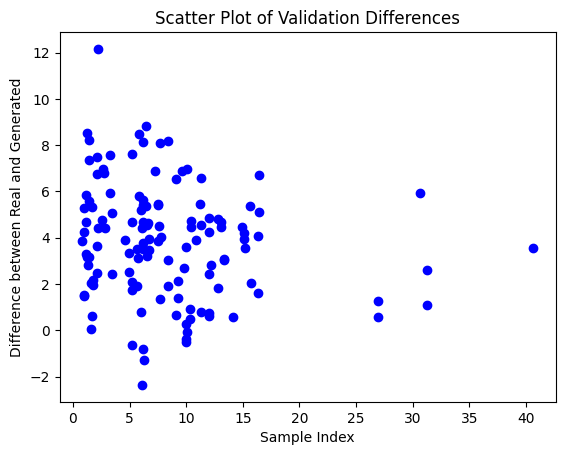

4/4 [==============================] - 0s 6ms/step
Epoch: 2/800, D Loss: [0.6866339  0.55859375], G Loss: 0.23775842785835266, Val D Loss: [0.68729779 0.5390625 ]
4/4 [==============================] - 0s 7ms/step
Epoch: 3/800, D Loss: [0.68734145 0.53515625], G Loss: 0.23936817049980164, Val D Loss: [0.6870358 0.546875 ]
4/4 [==============================] - 0s 5ms/step
Epoch: 4/800, D Loss: [0.68714774 0.5546875 ], G Loss: 0.23870226740837097, Val D Loss: [0.68740517 0.53125   ]
4/4 [==============================] - 0s 5ms/step
Epoch: 5/800, D Loss: [0.6868112  0.55859375], G Loss: 0.23917995393276215, Val D Loss: [0.68705064 0.55078125]
4/4 [==============================] - 0s 7ms/step
Epoch: 6/800, D Loss: [0.68610716 0.546875  ], G Loss: 0.23747983574867249, Val D Loss: [0.68699703 0.53515625]
4/4 [==============================] - 0s 7ms/step
Epoch: 7/800, D Loss: [0.6878848  0.52734375], G Loss: 0.2393762767314911, Val D Loss: [0.6872009  0.54296875]
4/4 [====================

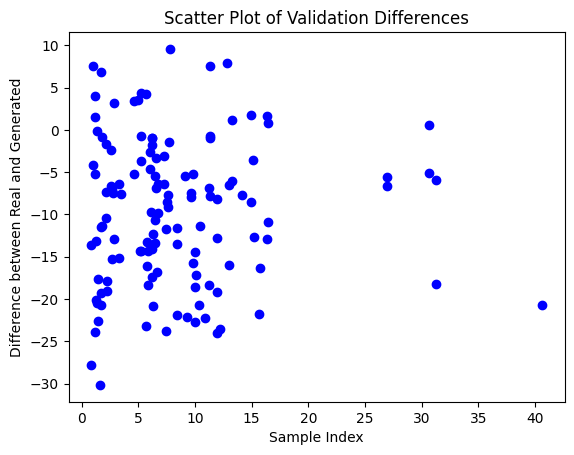

4/4 [==============================] - 0s 7ms/step
Epoch: 102/800, D Loss: [0.69498503 0.5546875 ], G Loss: 0.23585227131843567, Val D Loss: [0.69487906 0.53125   ]
4/4 [==============================] - 0s 9ms/step
Epoch: 103/800, D Loss: [0.69709027 0.515625  ], G Loss: 0.23698006570339203, Val D Loss: [0.69600546 0.51171875]
4/4 [==============================] - 0s 10ms/step
Epoch: 104/800, D Loss: [0.69820726 0.53125   ], G Loss: 0.23775017261505127, Val D Loss: [0.69507214 0.52734375]
4/4 [==============================] - 0s 7ms/step
Epoch: 105/800, D Loss: [0.6977315  0.50390625], G Loss: 0.2368776500225067, Val D Loss: [0.6954892 0.515625 ]
4/4 [==============================] - 0s 6ms/step
Epoch: 106/800, D Loss: [0.6960402  0.55078125], G Loss: 0.23911145329475403, Val D Loss: [0.69508287 0.51953125]
4/4 [==============================] - 0s 6ms/step
Epoch: 107/800, D Loss: [0.6965736 0.5390625], G Loss: 0.23754404485225677, Val D Loss: [0.69483688 0.515625  ]
4/4 [=========

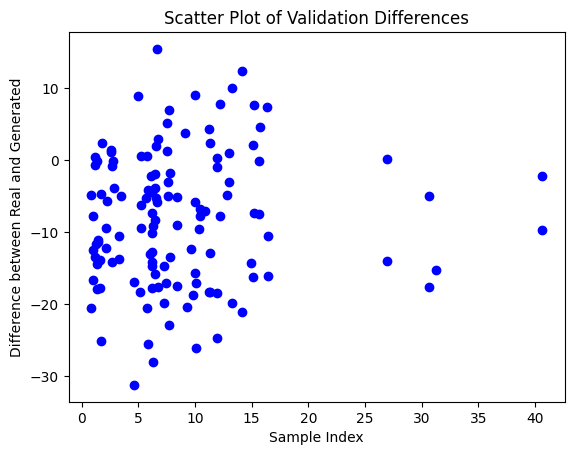

4/4 [==============================] - 0s 6ms/step
Epoch: 202/800, D Loss: [0.6983213  0.49609375], G Loss: 0.23700153827667236, Val D Loss: [0.69585973 0.5078125 ]
4/4 [==============================] - 0s 8ms/step
Epoch: 203/800, D Loss: [0.7001577  0.47265625], G Loss: 0.23720207810401917, Val D Loss: [0.69739294 0.50390625]
4/4 [==============================] - 0s 7ms/step
Epoch: 204/800, D Loss: [0.6977606  0.49609375], G Loss: 0.2380681037902832, Val D Loss: [0.69583058 0.53125   ]
4/4 [==============================] - 0s 7ms/step
Epoch: 205/800, D Loss: [0.6970931 0.53125  ], G Loss: 0.2380593717098236, Val D Loss: [0.69642383 0.51953125]
4/4 [==============================] - 0s 6ms/step
Epoch: 206/800, D Loss: [0.6966058 0.53125  ], G Loss: 0.23756852746009827, Val D Loss: [0.69624367 0.51953125]
4/4 [==============================] - 0s 7ms/step
Epoch: 207/800, D Loss: [0.6972518  0.51953125], G Loss: 0.2373170256614685, Val D Loss: [0.69688627 0.5078125 ]
4/4 [============

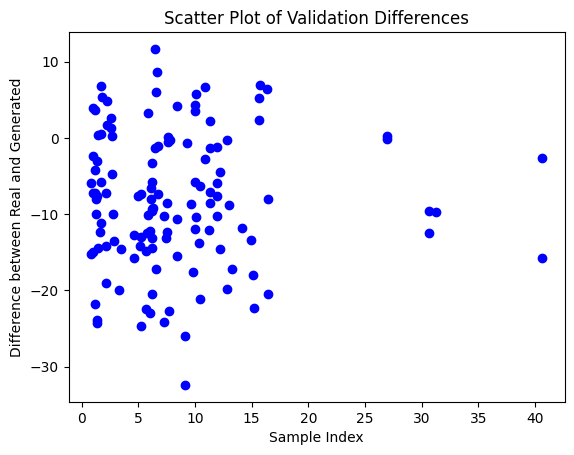

4/4 [==============================] - 0s 6ms/step
Epoch: 302/800, D Loss: [0.6996323  0.50390625], G Loss: 0.2357354760169983, Val D Loss: [0.69712964 0.515625  ]
4/4 [==============================] - 0s 6ms/step
Epoch: 303/800, D Loss: [0.69847894 0.5234375 ], G Loss: 0.23711809515953064, Val D Loss: [0.69752654 0.5078125 ]
4/4 [==============================] - 0s 7ms/step
Epoch: 304/800, D Loss: [0.69813573 0.49609375], G Loss: 0.2367725968360901, Val D Loss: [0.69805732 0.50390625]
4/4 [==============================] - 0s 6ms/step
Epoch: 305/800, D Loss: [0.6991167 0.5234375], G Loss: 0.2382955253124237, Val D Loss: [0.69749379 0.51171875]
4/4 [==============================] - 0s 9ms/step
Epoch: 306/800, D Loss: [0.69868875 0.515625  ], G Loss: 0.23595881462097168, Val D Loss: [0.69761714 0.50390625]
4/4 [==============================] - 0s 9ms/step
Epoch: 307/800, D Loss: [0.6993607  0.51953125], G Loss: 0.23655477166175842, Val D Loss: [0.6973252  0.51171875]
4/4 [==========

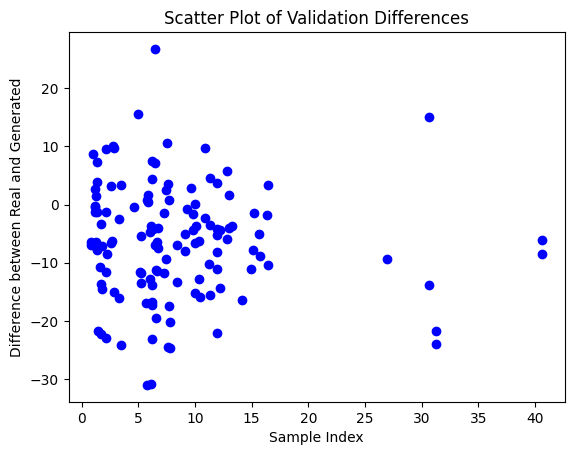

4/4 [==============================] - 0s 7ms/step
Epoch: 402/800, D Loss: [0.7001953  0.52734375], G Loss: 0.23645691573619843, Val D Loss: [0.6988745  0.50390625]
4/4 [==============================] - 0s 7ms/step
Epoch: 403/800, D Loss: [0.6991163 0.5078125], G Loss: 0.23401182889938354, Val D Loss: [0.69793552 0.51171875]
4/4 [==============================] - 0s 6ms/step
Epoch: 404/800, D Loss: [0.7001282 0.5390625], G Loss: 0.2365913689136505, Val D Loss: [0.69796294 0.51171875]
4/4 [==============================] - 0s 7ms/step
Epoch: 405/800, D Loss: [0.699823  0.5234375], G Loss: 0.23559504747390747, Val D Loss: [0.69835991 0.50390625]
4/4 [==============================] - 0s 10ms/step
Epoch: 406/800, D Loss: [0.6993943 0.5234375], G Loss: 0.23567096889019012, Val D Loss: [0.69802904 0.5       ]
4/4 [==============================] - 0s 12ms/step
Epoch: 407/800, D Loss: [0.70057034 0.49609375], G Loss: 0.23591729998588562, Val D Loss: [0.69793326 0.51171875]
4/4 [============

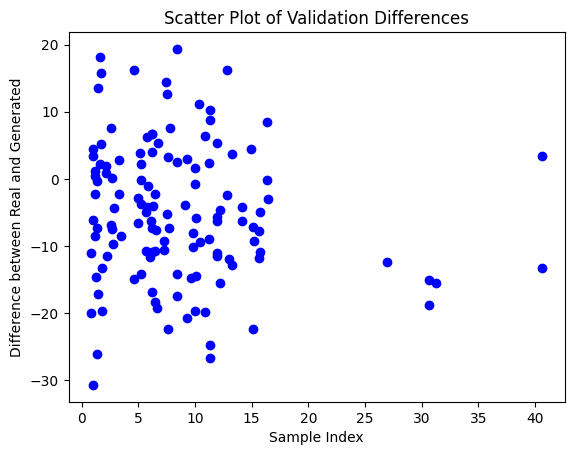

4/4 [==============================] - 0s 7ms/step
Epoch: 502/800, D Loss: [0.7003854 0.5234375], G Loss: 0.234264075756073, Val D Loss: [0.69979379 0.50390625]
4/4 [==============================] - 0s 6ms/step
Epoch: 503/800, D Loss: [0.7026746  0.48828125], G Loss: 0.23601999878883362, Val D Loss: [0.69862977 0.5078125 ]
4/4 [==============================] - 0s 7ms/step
Epoch: 504/800, D Loss: [0.7012416 0.515625 ], G Loss: 0.23236960172653198, Val D Loss: [0.6991396  0.50390625]
4/4 [==============================] - 0s 7ms/step
Epoch: 505/800, D Loss: [0.7024262  0.52734375], G Loss: 0.23309461772441864, Val D Loss: [0.69813383 0.515625  ]
4/4 [==============================] - 0s 6ms/step
Epoch: 506/800, D Loss: [0.7002933 0.5078125], G Loss: 0.23455585539340973, Val D Loss: [0.69976482 0.50390625]
4/4 [==============================] - 0s 7ms/step
Epoch: 507/800, D Loss: [0.6993166  0.51171875], G Loss: 0.23451444506645203, Val D Loss: [0.69939584 0.5       ]
4/4 [=============

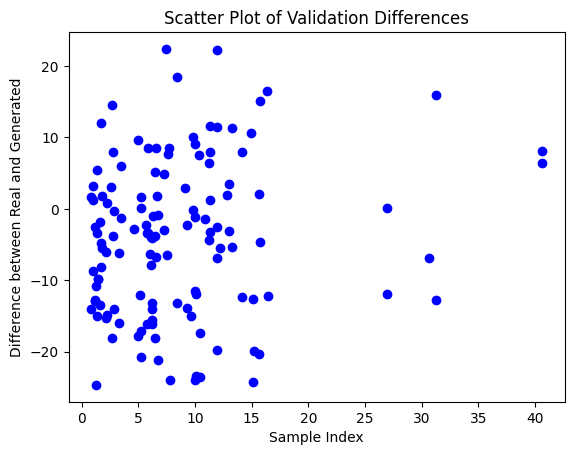

4/4 [==============================] - 0s 7ms/step
Epoch: 602/800, D Loss: [0.7009716  0.51953125], G Loss: 0.234384685754776, Val D Loss: [0.70019138 0.50390625]
4/4 [==============================] - 0s 6ms/step
Epoch: 603/800, D Loss: [0.70201045 0.484375  ], G Loss: 0.23297452926635742, Val D Loss: [0.70047379 0.50390625]
4/4 [==============================] - 0s 7ms/step
Epoch: 604/800, D Loss: [0.70144856 0.515625  ], G Loss: 0.23388363420963287, Val D Loss: [0.69974095 0.5078125 ]
4/4 [==============================] - 0s 7ms/step
Epoch: 605/800, D Loss: [0.7039333 0.4921875], G Loss: 0.2339116930961609, Val D Loss: [0.70028526 0.5       ]
4/4 [==============================] - 0s 7ms/step
Epoch: 606/800, D Loss: [0.7011568 0.515625 ], G Loss: 0.23246559500694275, Val D Loss: [0.7004388  0.50390625]
4/4 [==============================] - 0s 7ms/step
Epoch: 607/800, D Loss: [0.70028293 0.515625  ], G Loss: 0.23425719141960144, Val D Loss: [0.70018142 0.50390625]
4/4 [============

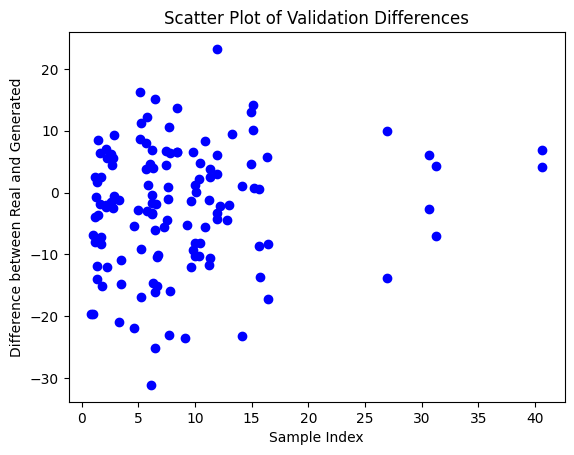

4/4 [==============================] - 0s 7ms/step
Epoch: 702/800, D Loss: [0.7025999 0.5078125], G Loss: 0.23301933705806732, Val D Loss: [0.70088992 0.50390625]
4/4 [==============================] - 0s 7ms/step
Epoch: 703/800, D Loss: [0.7007322 0.5078125], G Loss: 0.2339339554309845, Val D Loss: [0.70075324 0.50390625]
4/4 [==============================] - 0s 6ms/step
Epoch: 704/800, D Loss: [0.70265365 0.49609375], G Loss: 0.23360945284366608, Val D Loss: [0.70187932 0.5       ]
4/4 [==============================] - 0s 6ms/step
Epoch: 705/800, D Loss: [0.70430493 0.48828125], G Loss: 0.23371152579784393, Val D Loss: [0.70127311 0.5       ]
4/4 [==============================] - 0s 8ms/step
Epoch: 706/800, D Loss: [0.70426965 0.4765625 ], G Loss: 0.23356327414512634, Val D Loss: [0.70181075 0.5078125 ]
4/4 [==============================] - 0s 7ms/step
Epoch: 707/800, D Loss: [0.70373714 0.5078125 ], G Loss: 0.2331799566745758, Val D Loss: [0.70017311 0.5       ]
4/4 [===========

In [56]:
# Train the GAN with validation
import matplotlib.pyplot as plt

train_gan(generator, discriminator, gan, epochs=800, batch_size=128, latent_dim=latent_dim, val_gen=val_gen,keep_cols=keep_cols)

1024/1024 [==============================] - 6s 5ms/step


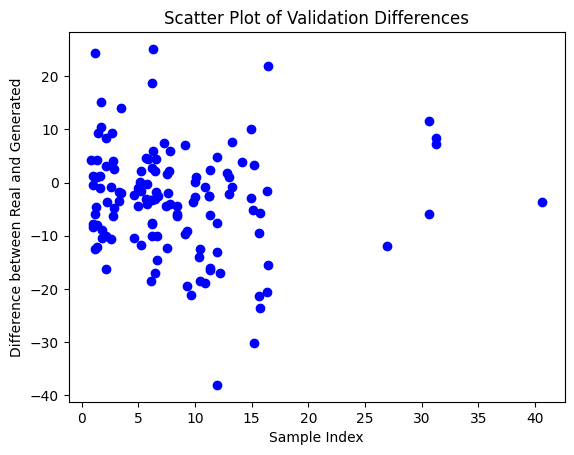

In [57]:
# data = validate_generator()
data = validate_generator(n_samp=1024*32)
x_values = [ datum[0] for datum in data]
y_values = [ datum[1] for datum in data]

# Create a scatter plot
plt.scatter(x_values, y_values, color='blue')

# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('Difference between Real and Generated')
plt.title('Scatter Plot of Validation Differences')

# Show the plot
plt.show()

In [92]:
# Define the generator model
def build_generator(input_sequence_shape, output_sequence_shape):
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_dim=input_sequence_shape),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(output_sequence_shape, activation='linear')
    ])
    return model

In [180]:
# pd.DataFrame(next(train_gen)[0]).isna().any().any()

In [127]:
soc_model = build_generator(27,1)

In [182]:
from tensorflow.keras import optimizers

# Define the training parameters
epochs = 1
batch_size = 128
learning_rate = 0.001

# Compile the generator model
soc_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',  # Mean Squared Error loss is commonly used for regression tasks
                  metrics=['mae'])  # Mean Absolute Error as a metric for monitoring


In [184]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [256]:
# Assuming the last column is the target variable
X = scaled_numeric_df.iloc[:, :-1]
y = scaled_numeric_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [257]:
y_test

6188    0.025221
6660    0.019593
5014    0.020407
6029    0.023147
665     0.375401
          ...   
841     0.217046
644     0.376792
1920    0.034159
526     0.429653
125     0.054021
Name: imp_c_float, Length: 492, dtype: float64

In [258]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),

    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Change activation if it's a classification problem
])


In [259]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')  # Change loss if it's a classification problem


In [260]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=1000, batch_size=128, verbose=1)

Epoch 1/1000
13/13 [==============================] - 1s 17ms/step - loss: 0.0780 - val_loss: 0.0423
Epoch 2/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0196 - val_loss: 0.0136
Epoch 3/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.0098
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.0080
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0084 - val_loss: 0.0077
Epoch 6/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0068
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 9/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 10/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.006

In [261]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


16/16 [==============================] - 0s 2ms/step - loss: 0.0057
Test Loss: 0.005726647563278675


In [262]:
predictions = model.predict(X_test)
predictions = [pred[0] for pred in predictions]

16/16 [==============================] - 0s 2ms/step


In [263]:
# predictions_reshaped = predictions.reshape(-1, 1)
dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Assuming 0.5 is the median value after MinMax scaling
target_column_index = -1  # Assuming the last column is the target variable
dummy_array[:, target_column_index] = predictions

target_column_index = -1  # Assuming the last column is the target variable
dummy_array[:, target_column_index] = predictions

inversed_dummy_array = scaler.inverse_transform(dummy_array)

inversed_predictions = inversed_dummy_array[:, target_column_index]


dummy_array[:, target_column_index] = y_test

inversed_dummy_array = scaler.inverse_transform(dummy_array)


inversed_truth = inversed_dummy_array[:, target_column_index]
# inversed_predictions

In [264]:
from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(inversed_truth, inversed_predictions)
print(f'R-squared: {r_squared}')


R-squared: 0.6517412442271073


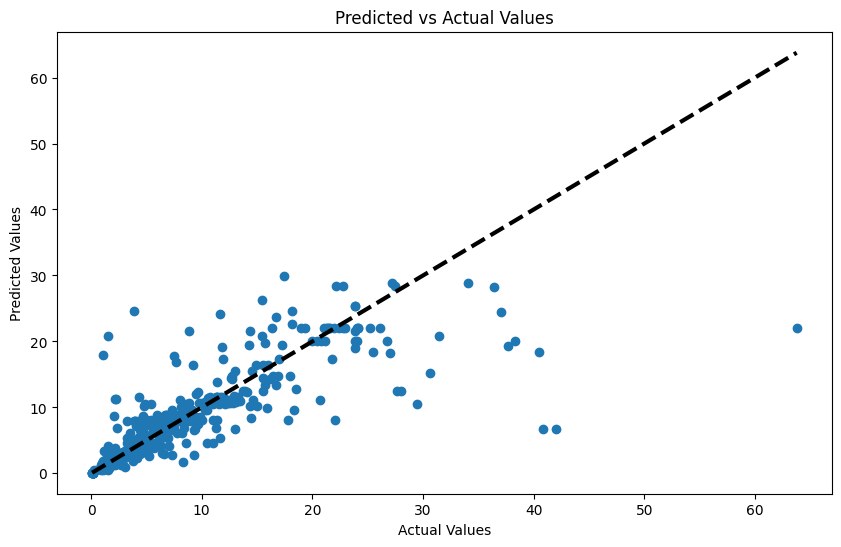

In [265]:
import matplotlib.pyplot as plt

# Make predictions on the test set
# predictions = model.predict(X_test).flatten()

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(inversed_truth, inversed_predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([inversed_truth.min(), inversed_truth.max()], [inversed_truth.min(), inversed_truth.max()], 'k--', lw=3)  # Diagonal line
plt.show()
